# Field cage nutrient analysis -- Plant nutrients

This script analyzes the grass nutrient contents (protein and carbohydrates) for field cages

Please see manuscript for specific methodology.

This script does the following:

1) analyzes differences between fertilization treatment and grass protein/carbohydrate content
2) analyzes plant species and soil composition differences by fertilization treatment
3) analyze plant content content with soil nitrogen content
4) analyzes plant ground cover differences by fertilization treatment

Manuscript figure preparation happens in the `03_field_cages_intake_target_mauscript_figure_code.ipynb` file

In [4]:
load_packages <- function(packages) {
  # Check for uninstalled packages
  uninstalled <- packages[!packages %in% installed.packages()[,"Package"]]
  
  # Install uninstalled packages
  if(length(uninstalled)) install.packages(uninstalled, dependencies = TRUE)

  # Load all packages
  for (pkg in packages) {
    if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
      message(paste("Failed to load package:", pkg))
    }
  }
}

# List of packages to check, install, and load
packages <- c("mgcv", "MuMIn", "multcomp", "gratia", 
              "ggpubr", "patchwork", "broom", "knitr", "janitor", 
              "here","ggpubr","MetBrewer","GGally","tidyverse")

load_packages(packages)

i_am('README.md')

# Functions
                   
## Standard error
std <- function(x) sd(x)/sqrt(length(x))


# Setting R options for jupyterlab
options(repr.plot.width = 10, repr.plot.height = 10,repr.matrix.max.rows=10)


here() starts at /home/datascience/herbivore_nutrient_interactions



# Section 1 - Plant nutrients over time by fertilization treatment

## read in data

In [5]:
plant_nutrients <- read_csv(here('data/raw/field_cage_experiment/Field_Cage_Nutrients_Through_Time.csv'),show_col_types = FALSE) |>
    clean_names() |>
    select(x1,plot,cage,treatment,species,chn_weight_mg,c_mg_mg,n_mg_mg,protein_mg_mg,carb_mg_mg,carb_prot_ratio) |>
    rename(date = x1) |>
    mutate(date = parse_date_time(date,orders='mdy'),
        across(c(date,plot,cage,treatment,species),~as.factor(.)),
        treatment = fct_recode(treatment, "None" = "0", "Medium" = "M", "High" = "H",
                                "None" = '1', "Medium" = "2", "High" = "3"),
        plot_cage = factor(paste0(plot,"_",cage)))

plant_nutrients

New names:
• `` -> `...1`


date,plot,cage,treatment,species,chn_weight_mg,c_mg_mg,n_mg_mg,protein_mg_mg,carb_mg_mg,carb_prot_ratio,plot_cage
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2015-12-01,0-1,5,None,Nutgrass,2.112,0.40997,0.02689,0.1361,0.120,0.8816132,0-1_5
2015-12-01,0-1,5,None,Wallaby,2.818,0.41875,0.02299,0.1410,0.105,0.7448132,0-1_5
2015-12-01,0-1,5,None,Plaspladium,2.170,0.39406,0.03146,0.1509,0.096,0.6360841,0-1_5
2015-12-01,0-1,6,None,Enteropogon,2.325,0.40071,0.02328,0.0713,0.171,2.3998638,0-1_6
2015-12-01,0-1,6,None,Nutgrass,2.244,0.39387,0.02247,0.1334,0.120,0.8993145,0-1_6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2015-11-11,H-2,Ext,High,Wallaby,2.051,0.42581,0.02388,0.2224,0.131,0.5890989,H-2_Ext
2015-11-11,H-2,Ext,High,Enteropogon,2.377,0.42864,0.02832,0.2202,0.118,0.5358819,H-2_Ext
2015-11-11,H-3,Ext,High,Nutgrass,2.207,0.42253,0.02804,0.2603,0.120,0.4610205,H-3_Ext


## Raw data visualization

using ggpairs to be pithy..

In [5]:
numeric_columns <- c("chn_weight_mg", "c_mg_mg", "n_mg_mg","protein_mg_mg","carb_mg_mg")
factor_columns <- c('date','plot','treatment','species')

my_dens <- function(data, mapping,...) {
  ggplot(data = data, mapping=mapping) +
    geom_density(..., alpha = 0.7, fill = NA) 
}


date_raw_graph <- plant_nutrients |>
    dplyr::select(!c(plot_cage,cage)) |>
    ggpairs(aes(color=date),columns = numeric_columns,diag = list(continuous = my_dens))  +
    MetBrewer::scale_color_met_d(name='Kandinsky') +
    theme_pubr()

plot_raw_graph <- plant_nutrients |>
    dplyr::select(!c(plot_cage,cage)) |>
    ggpairs(aes(color=plot),columns = numeric_columns,diag = list(continuous = my_dens))  +
    MetBrewer::scale_color_met_d(name='Homer1') +
    theme_pubr()

treatment_raw_graph <- plant_nutrients |>
    dplyr::select(!c(plot_cage,cage)) |>
    ggpairs(aes(color=treatment),columns = numeric_columns,diag = list(continuous = my_dens))  +
    MetBrewer::scale_color_met_d(name='Derain') +
    theme_pubr()



In [8]:
# Define the output directory
output_dir <- here('output/field_cage_experiment/raw_visualization/')

# List of plots and their corresponding file names
plots <- list(
  "plant_nutrients_date_raw_graph" = date_raw_graph,
  "plant_nutrients_plot_raw_graph" = plot_raw_graph,
  "plant_nutrients_treatment_raw_graph" = treatment_raw_graph
)

# Loop through each plot and save it
for (name in names(plots)) {
  ggsave(
    filename = file.path(output_dir, paste0(name, ".png")),
    plot = plots[[name]],
    width = 10, height = 10, dpi = 300
  )
}

Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`

## Modeling Overview

In this analysis, we are evaluating four Generalized Additive Models (GAMs) to understand the effects of fertilizer treatment and date on plant protein and carbohydrate content. Each model differs in the complexity of its random effects structure. Here is a summary of each model:

### Model 1: Full Model with Cross and Nested Random Effects

- **Fixed Effects**: Includes `treatment` and `date`, as well as their interaction (`treatment * date`).
- **Random Effects**: 
  - `s(species, bs="re")`: Random effect for different grass species.
  - `s(plot_cage, bs="re")`: Random effect for spatial positioning within plot cages.
- **Purpose**: This model captures both the fixed effects of treatment and date, along with random variations across species and spatial positions, providing a comprehensive view of the variability in plant nutrient content.

### Model 2: Removed Spatial Nested Random Effect

- **Fixed Effects**: Same as Model 1, including `treatment`, `date`, and their interaction.
- **Random Effects**:
  - `s(species, bs="re")`: Random effect for different grass species.
- **Purpose**: This model simplifies the random effects structure by excluding the spatial random effect (`plot_cage`). It helps to assess how removing the spatial component affects the fit and interpretation of the model.

### Model 3: No Random Effects of Grass Species and Spatial Positioning

- **Fixed Effects**: Includes `treatment` and `date`, with their interaction.
- **Random Effects**: None.
- **Purpose**: This model serves as a baseline by including only the fixed effects and excluding all random effects. It provides a straightforward view of the impact of treatment and date on nutrient content without accounting for variability due to species or spatial positioning.

### Model 4: Intercept Only Model

- **Fixed Effects**: Only includes an intercept term.
- **Random Effects**: None.
- **Purpose**: This model acts as a null model or intercept-only model. It estimates the overall mean of the response variables (`carb_mg_mg` and `protein_mg_mg`) without considering any predictors. This model helps in understanding the baseline level of nutrient content.

### Summary

By comparing these models, we aim to understand how different levels of model complexity (in terms of random effects) impact the fit and interpretation of our GAMs. The results from these models will help us identify the most appropriate model structure for explaining variations in plant protein and carbohydrate content


In [9]:

# model 1: full model with species, plot, and cage random effects
mod1 <- gam(list(
  carb_mg_mg ~ treatment * date + s(species,bs="re") + s(plot,bs="re") + s(cage,bs="re"),
  protein_mg_mg ~ treatment * date + s(species,bs="re") + s(plot,bs="re") + s(cage,bs="re")),
  family=mvn(d=2),select=TRUE, data=plant_nutrients
)


# model 2: full model with species and plot random effects
mod2 <- gam(list(
  carb_mg_mg ~ treatment * date + s(species,bs="re") + s(plot,bs="re"),
  protein_mg_mg ~ treatment * date + s(species,bs="re") + s(plot,bs="re")),
  family=mvn(d=2),select=TRUE, data=plant_nutrients
)



# model 3: removed spatial nested random effect
mod3 <- gam(list(
  carb_mg_mg ~ treatment * date + s(species,bs="re"),
  protein_mg_mg ~ treatment * date + s(species,bs="re")),
  family=mvn(d=2),select=TRUE, data=plant_nutrients
)

# model 4: no random effects of grass species and spatial positioning
mod4 <- gam(list(
  carb_mg_mg ~ treatment * date,
  protein_mg_mg ~ treatment * date),
  family=mvn(d=2),select=TRUE, data=plant_nutrients
)

# model 5: intercept only model
mod5 <- gam(list(
  carb_mg_mg ~ 1,
  protein_mg_mg ~ 1),
  family=mvn(d=2),select=TRUE, data=plant_nutrients
)

## Model Diagnostics

To see how well these models fit, I will run `mgcv::gam.check()` on it


Method: REML   Optimizer: outer newton
full convergence after 21 iterations.
Gradient range [-0.0003103183,0.0006675309]
(score -1038.257 & scale 1).
Hessian positive definite, eigenvalue range [0.04610883,3.930483].
Model rank =  127 / 127 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'   edf k-index p-value
s(species)    7.00  4.32      NA      NA
s(plot)       9.00  1.07      NA      NA
s(cage)      37.00  2.50      NA      NA
s.1(species)  7.00  5.02      NA      NA
s.1(plot)     9.00  7.42      NA      NA
s.1(cage)    37.00 13.88      NA      NA


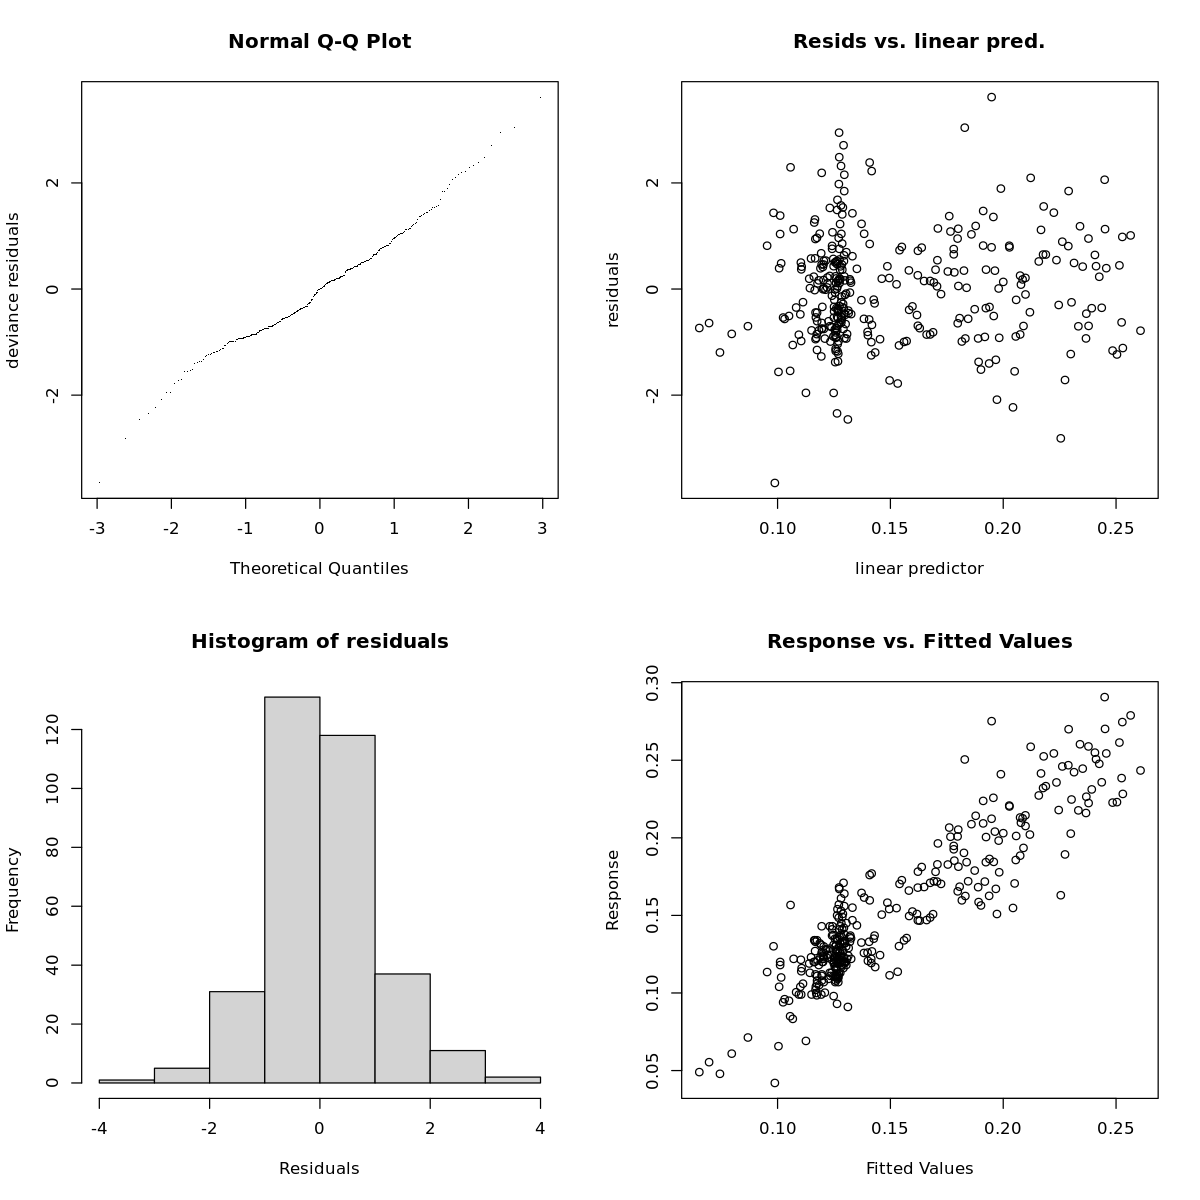

In [10]:
gam.check(mod1)

These diagnostic plots indicate these models are pretty well fit.

there is some discernable relationship in the variance plot, but it could be worse

## Model selection criteria 

In [11]:
# Model selection using AIC, BIC, and AICc
bic <- BIC(mod1, mod2, mod3, mod4, mod5) |>  # Bayesian Information Criterion
    mutate(deltaBIC = BIC - min(BIC)) |>
    rownames_to_column('model') |>
    dplyr::select(model,BIC,deltaBIC)

aic <- AIC(mod1, mod2, mod3, mod4, mod5)  |>  # Akaike Information Criterion
    mutate(deltaAIC = AIC - min(AIC)) |>
    rownames_to_column('model') |>
    dplyr::select(model,AIC,deltaAIC)

aicc <- AICc(mod1, mod2, mod3, mod4, mod5)  |>  # AIC adjusted for small sample size
    mutate(deltaAICc = AICc - min(AICc)) |>
    rownames_to_column('model') |>
    dplyr::select(model,AICc,deltaAICc)

model_selection_tables <- bic |>
    left_join(aic,by='model') |>
    left_join(aicc,by='model') |>
    mutate(experiment = 'plant_nutrients_through_time')

In [12]:
model_selection_tables |> arrange(deltaAIC)

model,BIC,deltaBIC,AIC,deltaAIC,AICc,deltaAICc,experiment
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
mod1,-2012.394,69.42298,-2223.967,0.000000,-2130.196,54.63740,plant_nutrients_through_time
mod2,-2081.817,0.00000,-2214.475,9.491908,-2184.833,0.00000,plant_nutrients_through_time
mod3,-2059.623,22.19326,-2157.263,66.704222,-2142.409,42.42384,plant_nutrients_through_time
mod4,-2018.892,62.92436,-2084.496,139.471257,-2078.167,106.66645,plant_nutrients_through_time
mod5,-1997.612,84.20478,-2013.232,210.735098,-2012.861,171.97190,plant_nutrients_through_time


### selection criteria did not agree

there were significant differences between the selection criteria. BIC and AICc selected model 2 whereas AIC selected model 1

Lets view the estimates from both models to see where they agree and disagree

In [13]:
selection_testing_data <- plant_nutrients


# Model 1
selection_testing_data$mod1_pred_carb <- predict(mod1, newdata = plant_nutrients, type = "response")[, 1]
selection_testing_data$mod1_pred_protein <- predict(mod1, newdata = plant_nutrients, type = "response")[, 2]

# Model 2
selection_testing_data$mod2_pred_carb <- predict(mod2, newdata = plant_nutrients, type = "response")[, 1]
selection_testing_data$mod2_pred_protein <- predict(mod2, newdata = plant_nutrients, type = "response")[, 2]



In [14]:
selection_testing_data2 <- selection_testing_data |>
  select(carb_mg_mg, protein_mg_mg, mod1_pred_carb, mod1_pred_protein, mod2_pred_carb, mod2_pred_protein) %>%
  mutate(row = row_number()) |>
  pivot_longer(
    cols = starts_with("mod1_pred") | starts_with("mod2_pred") | contains("carb") | contains("protein"),
    names_to = c("type", "component"),
    names_pattern = "(.*)_(.*)$",
    values_to = "value"
  ) |>
  mutate(
    component = case_when(
      type == 'carb_mg' ~ 'carb',
      type == 'protein_mg' ~ 'protein',
      TRUE ~ component
    ),
    type = case_when(
      type %in% c('carb_mg', 'protein_mg') ~ 'actual',
      TRUE ~ type
    )
  ) |>
  pivot_wider(
    names_from = component,
    values_from = value
  )


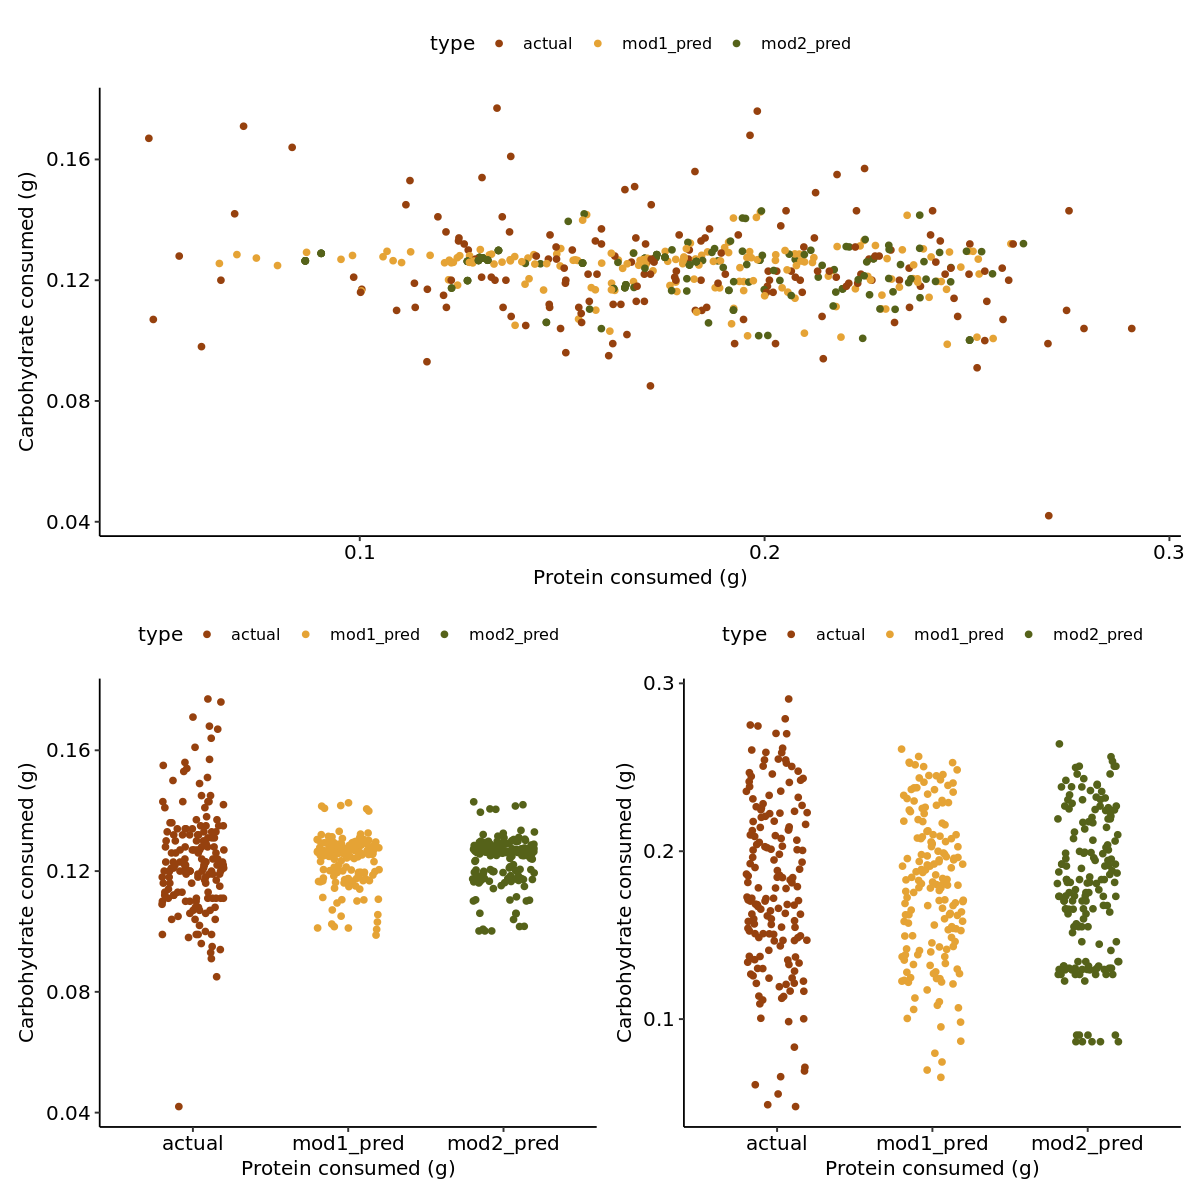

In [15]:
p1 <- selection_testing_data2 |>
    #filter(type != 'actual') |>
    ggplot(aes(x=protein,y=carb,color=type)) + 
        geom_point() +  
        #xlim(0,.055) + ylim(0,.055) + 
        theme_pubr() + 
        ylab("Carbohydrate consumed (g)") +
        xlab("Protein consumed (g)") + 
        scale_color_met_d(name='Degas') 

p2 <- selection_testing_data2 |>
    #filter(type != 'actual') |>
    ggplot(aes(x=type,y=carb,color=type)) + 
        geom_jitter(width=0.2,height=0) +  
        #xlim(0,.055) + ylim(0,.055) + 
        theme_pubr() + 
        ylab("Carbohydrate consumed (g)") +
        xlab("Protein consumed (g)") + 
        scale_color_met_d(name='Degas') 

p3 <- selection_testing_data2 |>
    #filter(type != 'actual') |>
    ggplot(aes(x=type,y=protein,color=type)) + 
        geom_jitter(width=0.2,height=0) +  
        #xlim(0,.055) + ylim(0,.055) + 
        theme_pubr() + 
        ylab("Carbohydrate consumed (g)") +
        xlab("Protein consumed (g)") + 
        scale_color_met_d(name='Degas') 

(p1) / (p2 + p3)

### verdict

The predictions really dont change much. I think I will stick with model 1 as it better portrays the nature of the data, even if the predictions remain the same.

## Final model summary

In [16]:
summary(mod1)


Family: Multivariate normal 
Link function: 

Formula:
carb_mg_mg ~ treatment * date + s(species, bs = "re") + s(plot, 
    bs = "re") + s(cage, bs = "re")
protein_mg_mg ~ treatment * date + s(species, bs = "re") + s(plot, 
    bs = "re") + s(cage, bs = "re")

Parametric coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       0.126994   0.007285  17.432  < 2e-16 ***
treatmentMedium                  -0.020282   0.007171  -2.828  0.00468 ** 
treatmentHigh                    -0.011134   0.007171  -1.553  0.12052    
date2015-11-25                   -0.009444   0.007061  -1.338  0.18103    
date2015-12-01                   -0.012119   0.005692  -2.129  0.03323 *  
treatmentMedium:date2015-11-25    0.018556   0.009986   1.858  0.06314 .  
treatmentHigh:date2015-11-25      0.004444   0.009986   0.445  0.65626    
treatmentMedium:date2015-12-01    0.019111   0.007990   2.392  0.01677 *  
treatmentHigh:date2015-12-01      0.00

## Key Findings

Plant Carbohydrate Content: The application of urea (nitrogen) as a medium treatment significantly reduced carbohydrate content compared to the control, particularly on December 1, 2015. Significant species-specific variation in carbohydrate content was observed, while plot and cage variability were not significant.

Plant Protein Content: Surprisingly, despite the urea (nitrogen) fertilization, the high treatment reduced protein levels in plants, contrary to what might be expected. Significant changes in protein content were observed on November 25 and December 1, 2015. There were notable effects from species, plot, and cage variability, with species and plot effects being particularly strong.

Overall Model Performance: The model explains 70.4% of the deviance in carbohydrate and protein content, indicating a very good fit.

## Model outputs and raw data 

I am going to get the estimated marginal means for `treatment`,`date`, and `treatment:date` and output as a dataframe

I will also write out to disk the model object


In [17]:

plant_nutrient_exp_preds <- expand.grid(
    species = unique(plant_nutrients$species),
    treatment = unique(plant_nutrients$treatment),
    date = unique(plant_nutrients$date),
    plot = unique(plant_nutrients$plot),
    cage = unique(plant_nutrients$cage)
)


# Predict carbohydrate consumption
plant_nutrient_exp_preds$pred_carb <- predict(mod3, newdata = plant_nutrient_exp_preds, type = "response")[, 1]

# Predict protein consumption
plant_nutrient_exp_preds$pred_protein <- predict(mod3, newdata = plant_nutrient_exp_preds, type = "response")[, 2]

# Now averaging arcoss species, plot, and cage
plant_nutrient_exp_preds2 <- plant_nutrient_exp_preds |>
    group_by(date,treatment) |>
    summarize(pred_carb = mean(pred_carb),
           pred_protein = mean(pred_protein))

`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


In [18]:
write.csv(plant_nutrient_exp_preds2,here('data/processed/field_cage_experiment/plant_nutrient_predictions.csv'),row.names=FALSE)
write.csv(plant_nutrients,here('data/processed/field_cage_experiment/plant_nutrient_raw_data.csv'),row.names=FALSE)




write.csv(model_selection_tables, here("output/field_cage_experiment/plant_nutrient_model_selection_criteria_results.csv"),row.names=FALSE)


# Combine the lists into a single list
models <- list('mod1'= mod1, 'mod2' = mod2, 'mod3'= mod3, 'mod4'= mod4)

# Save the combined list to an RDS file
saveRDS(models, here("output/field_cage_experiment/model_objects/plant_nutrient_through_time_models.rds"))

# Section 2 - Species-specific and soil nutrient content by fertilization treatment

## read in data

In [19]:
plant_nutrients2 <- read.csv(here("data/raw/field_cage_experiment/Field_Cage_Nutrients_Through_Time.csv")) |>
    mutate(Treatment = fct_recode(Treatment, "None" = "0", "Medium" = "M", "High" = "H",
                                "None" = '1', "Medium" = "2", "High" = "3")) |> 
    clean_names() |>
    as_tibble() |>
    mutate(date = factor(parse_date_time(x,orders='mdy')))


soils <- readxl::read_xlsx(here('data/raw/field_cage_experiment/Aus_2015_ExpPlots_soil.xlsx')) |>
    clean_names() |>
    select(treatment,initial_no3,initial_no4) |>
    group_by(treatment) |>
    summarize(mean_no3 = mean(initial_no3),
             sd_no3 = sd(initial_no3),
             mean_no4 = mean(initial_no4),
             sd_no4 = sd(initial_no4)) |>
    mutate(treatment = fct_recode(treatment, "None" = "0", "Medium" = "M", "High" = "H"))

## Now combine the species plant and soil nutrient data

In [20]:


plant_species_soil_nutrient_by_treatment <- plant_nutrients2  |>
    select(plot,treatment,species,c_mg_mg,n_mg_mg,protein_mg_mg,carb_mg_mg,date) |>
    left_join(soils,by='treatment') |>
    group_by(date,treatment,species) |>
    summarize(`Plant C` = mean(c_mg_mg),
              `Plant N` = mean(n_mg_mg),
              `Plant Protein` = mean(protein_mg_mg),
              `Plant Carbohydrate` = mean(carb_mg_mg),
              `Soil NO3` = first(mean_no3),
              `Soil NO4` = first(mean_no4)) |>
    arrange(treatment,species,date) |>
    select(treatment,species,date,`Plant C`,`Plant N`,`Plant Protein`,`Plant Carbohydrate`,`Soil NO3`,`Soil NO4`)

plant_species_soil_nutrient_by_treatment

`summarise()` has grouped output by 'date', 'treatment'. You can override using
the `.groups` argument.


treatment,species,date,Plant C,Plant N,Plant Protein,Plant Carbohydrate,Soil NO3,Soil NO4
<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
None,Enteropogon,2015-11-11,0.4319933,0.03112333,0.1636333,0.1453333,1.386671,0.3312754
None,Enteropogon,2015-11-25,0.4136500,0.02150000,0.1935667,0.1153333,1.386671,0.3312754
None,Enteropogon,2015-12-01,0.4054009,0.02337409,0.1137636,0.1297727,1.386671,0.3312754
None,Nutgrass,2015-11-11,0.4247033,0.03152667,0.2279333,0.1443333,1.386671,0.3312754
None,Nutgrass,2015-11-25,0.4170000,0.02676333,0.2323333,0.1373333,1.386671,0.3312754
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
High,Nutgrass,2015-12-01,0.4174471,0.02656000,0.2271714,0.1257143,3.237535,4.207035
High,Plaspladium,2015-12-01,0.4003700,0.02904000,0.2333000,0.1200000,3.237535,4.207035
High,Wallaby,2015-11-11,0.4241033,0.02292000,0.2064333,0.1250000,3.237535,4.207035


In [21]:
write.csv(plant_species_soil_nutrient_by_treatment,here('data/processed/field_cage_experiment/plant_species_soil_nutrient_by_treatment.csv'),row.names=FALSE)


# Section 3 - Ground cover by fertilization treatment

We need to regression soil and plant nutrients together

- panel a: initial no3 to treatment
- panel b: initial no4 to treatment
- panel c: plant protein to no3
- panel d: plant protein to no4
- panel e: plant carbohydrate to no3
- panel f: plant carbohydrate to no4

## Read in data

using the dataframe frames from `section 2`

In [6]:
plant_dat <- read_csv(here('data/raw/field_cage_experiment/Field_Cage_Nutrients_Through_Time.csv'),show_col_types = FALSE) |>
    clean_names() |>
    select(x1,plot,cage,treatment,species,chn_weight_mg,c_mg_mg,n_mg_mg,protein_mg_mg,carb_mg_mg,carb_prot_ratio) |>
    rename(date = x1) |>
    mutate(date = parse_date_time(date,orders='mdy'),
        across(c(date,plot,cage,treatment,species),~as.factor(.)),
        treatment = fct_recode(treatment, "None" = "0", "Medium" = "M", "High" = "H",
                                "None" = '1', "Medium" = "2", "High" = "3")) |>
    dplyr::select(date,plot,treatment,protein_mg_mg,carb_mg_mg)

soils_dat_avg_treatment <- readxl::read_xlsx(here('data/raw/field_cage_experiment/Aus_2015_ExpPlots_soil.xlsx')) |>
    clean_names() |>
    mutate(treatment = fct_recode(treatment, "None" = "0", "Medium" = "M", "High" = "H")) |>
    select(treatment,initial_no3,initial_no4) |>
    group_by(treatment) |>
    summarize(mean_no3 = mean(initial_no3,na.rm=TRUE),
              mean_no4 = mean(initial_no4,na.rm=TRUE))

soil_plant_dat <- plant_dat |>
    left_join(soils_dat_avg_treatment,by='treatment')


New names:
• `` -> `...1`


In [7]:
soils_dat <- readxl::read_xlsx(here('data/raw/field_cage_experiment/Aus_2015_ExpPlots_soil.xlsx')) |>
    clean_names() |>
    mutate(treatment = fct_recode(treatment, "None" = "0", "Medium" = "M", "High" = "H")) |>
    select(treatment,initial_no3,initial_no4) 

## writing dataframes to disk

In [8]:
write.csv(soil_plant_dat,here('data/processed/field_cage_experiment/plant_soil_nutrient_data.csv'),row.names=FALSE)
write.csv(soils_dat,here('data/processed/field_cage_experiment/soil_nutrient_data'),row.names=FALSE)


# Section 4 - Ground cover by fertilization treatment

## Data Management Overview

This script processes ground cover survey data by:

1. **Data Import and Cleaning:** Loading raw data and standardizing column names.
2. **Feature Selection:** Extracting relevant vegetation and treatment variables.
3. **Treatment Categorization:** Classifying nitrogen treatments into 'None,' 'Medium,' and 'High' categories.
4. **Renaming:** Converting common plant names to scientific names.
5. **Data Transformation:** Converting specific values and calculating means by treatment.
6. **Handling Missing Data:** Replacing missing values for specific species with zero.



In [27]:
ground_cover_by_treatment <- read_csv(here('data/raw/field_cage_experiment/FieldCagePlantSurveys.xlsx - data.csv'),show_col_types = FALSE) |>
    clean_names() |>
    dplyr::select(n_treatment_kg_n_per_ha, liverseed_grass, enterpogam, wallaby_grass, nut_grass, stipa,plant_ground_cover_percent) |>
    mutate(treatment = case_when(n_treatment_kg_n_per_ha == 0 ~ 'None', n_treatment_kg_n_per_ha == 87.5 ~ 'Medium',
                                 n_treatment_kg_n_per_ha == 175 ~ 'High')) |>
    select(treatment,plant_ground_cover_percent,liverseed_grass,enterpogam,wallaby_grass,nut_grass,stipa) |>
    rename(`Urochloa panicoides` = liverseed_grass,
          `Enteropogon acicularis` = enterpogam,
          `Austrodanthonia caespitosa` = wallaby_grass,
           `Cyperus rotundus` = nut_grass,
           `stipa species` = stipa,
          plant_cover = plant_ground_cover_percent) |>
    mutate(across(!treatment, ~as.numeric(gsub('<5','5',.)))) |>
    group_by(treatment) |>
    summarize(across(where(is.numeric),~mean(.,na.rm=TRUE))) |>
    mutate(`stipa species` = replace_na(`stipa species`,0))

In [28]:
write.csv(ground_cover_by_treatment,here('data/processed/field_cage_experiment/plant_ground_cover_by_treatment.csv'),row.names=FALSE)
